# Desafio Nº4 - Construir un LSTM Bot QA

**Integrantes**:
- Santiago Belen. 

# Datos

Se utilizarán los datos disponibles del challenge **ConvAI2** (Conversational Intelligence Challenge 2) para construir un **LSTM Bot QA**  
[LINK](http://convai.io/data/)

- Para entrenar el modelo se usará la información de `text`, que está dentro de los mensajes de la lista `dialog` de cada conversación.
- Se cuenta con un total de **1.111** conversaciones, lo que suma **14.623** mensajes sin distinguir origen (Humano vs Bot).
- Se utilizarán para entrenamiento **10.626** pares de mensajes. Para la extracción se exige:
  - Que el mensaje siguiente pertenezca al mismo `conversation_id`.
  - Que ambos textos tengan **menos de 12 tokens**.


### Estructura del JSON

| Nivel | Tipo     | Descripción |
|:------|:---------|:------------|
| **data**  | list     | **Lista de conversaciones** |
| ├── *Elemento 0* | dict | *Una conversación* |
| │ ├── **dialog** | list | **Lista de mensajes** |
| │ │ ├── Mensaje 0 | dict | Contiene: `id`, `sender`, `text`, `evaluation_score`, `sender_class` |
| │ │ ├── Mensaje 1 | dict | Igual estructura que Mensaje 0 |
| │ │ └── ... |  |  |
| │ ├── start_time | str | Hora de inicio de la conversación |
| │ ├── end_time | str | Hora de finalización de la conversación |
| │ ├── bot_profile | list | Perfil del bot |
| │ ├── user_profile | list | Perfil del usuario |
| │ ├── eval_score | float o None | Puntaje de evaluación |
| │ ├── profile_match | str | Coincidencia de perfil |
| │ ├── participant1_id | dict | ID del participante 1 |
| │ └── participant2_id | dict | ID del participante 2 |
| ├── *Elemento 1* | dict | *Otra conversación* |
| └── *Elemento 2* | dict | *Otra conversación* |




In [2]:
import os, re, json, gzip, shutil, logging, pickle, gdown, numpy as np, pandas as pd, matplotlib.pyplot as plt,logging, pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from sklearn.model_selection import train_test_split
from pathlib import Path

# 1. Carga y selección del corpus

In [3]:
# Descargar el dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Cargar el archivo JSON
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

# 2. Análisis exploratorio

In [5]:
# Analisis Inicial

# Conversaciones
for idx, conv in enumerate(data):
    conv["conversation_id"] = idx

df_conv = pd.json_normalize(data)
print(df_conv.info())
display(df_conv.head())

# Mensajes
df_msg = pd.json_normalize(
    data,
    record_path="dialog",
    meta=["conversation_id"]   
)

# Métrica longitud
df_msg["n_words"] = df_msg["text"].str.split().str.len()

# Estadísticas
print(df_msg.groupby("sender_class")["n_words"].describe())

# Shift para ver siguiente hablante, AGRUPANDO por conversation_id
df_msg["next_sender"] = df_msg.groupby("conversation_id")["sender_class"].shift(-1)

# Conteo de pares
conteo = df_msg.value_counts(["sender_class", "next_sender"])

# Mostrar resultado
print(conteo)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dialog                   1111 non-null   object 
 1   start_time               1111 non-null   object 
 2   end_time                 1111 non-null   object 
 3   bot_profile              1111 non-null   object 
 4   user_profile             1111 non-null   object 
 5   eval_score               593 non-null    float64
 6   profile_match            1111 non-null   object 
 7   conversation_id          1111 non-null   int64  
 8   participant1_id.class    1111 non-null   object 
 9   participant1_id.user_id  1111 non-null   object 
 10  participant2_id.class    1111 non-null   object 
 11  participant2_id.user_id  1111 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 104.3+ KB
None


,dialog,start_time,end_time,bot_profile,user_profile,eval_score,profile_match,conversation_id,participant1_id.class,participant1_id.user_id,participant2_id.class,participant2_id.user_id
0,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 03:32:08.296000,2018-10-29 03:32:08.296000,[i like to talk but people have a hard time un...,"[i am a clean eater., my parents were both ver...",NaN,,0,User,User 00172,Bot,Bot 004
1,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 09:08:40,2018-10-29 09:12:32,"[my favorite singer is taylor swift., i love e...","[they are constantly on my back., i do not dri...",5.0,1,1,User,User 00892,Bot,Bot 002
2,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 12:12:12,2018-10-29 12:12:25,"[i'm pregnant with my first child., i read a b...","[i am a buddhist., i quit my job to pursue my ...",1.0,1,2,User,User 00892,Bot,Bot 006
3,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 12:23:56,2018-10-29 12:24:01,"[i like to ride horses., i help tend the field...","[i also like old school hip hop., i take dance...",1.0,1,3,User,User 00892,Bot,Bot 006
4,"[{'id': 0, 'sender': 'participant1', 'text': '...",2018-10-29 12:26:39,2018-10-29 12:33:51.064000,"[my wife spends all my money., i'm 40 years ol...","[i am in the third grade., mickey mouse is my ...",5.0,0,4,User,User 00892,Bot,Bot 002


               count      mean       std  min  25%  50%   75%    max
sender_class                                                        
Bot           6959.0  8.791206  9.163831  1.0  6.0  8.0  10.0  100.0
Human         7664.0  4.421712  5.898319  1.0  1.0  3.0   6.0  298.0
sender_class  next_sender
Human         Bot            6398
Bot           Human          5917
Human         Human           881
Bot           Bot             316
Name: count, dtype: int64


sender_class
Bot      8.791206
Human    4.421712
Name: n_words, dtype: float64


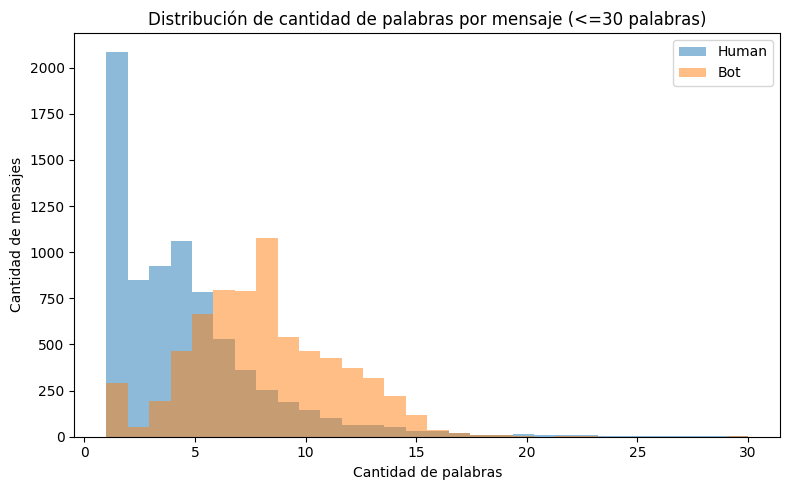

Mensajes totales: 14623
Mensajes usados (<=30 palabras): 14519
Mensajes descartados por ser demasiado largos: 104


In [6]:
# Promedio de palabras

# Promedio
promedios = df_msg.groupby('sender_class')['n_words'].mean()
print(promedios)

# Filtrar mensajes de hasta 30 palabras
df_filtrado = df_msg[df_msg['n_words'] <= 30]

# Histograma
plt.figure(figsize=(8,5))
for clase in ['Human', 'Bot']:
    subset = df_filtrado[df_filtrado['sender_class'] == clase]
    plt.hist(subset['n_words'], bins=30, alpha=0.5, label=clase)

plt.title('Distribución de cantidad de palabras por mensaje (<=30 palabras)')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de mensajes')
plt.legend()
plt.tight_layout()
plt.show()


# Resumen
total = len(df_msg)
filtrados = len(df_filtrado)
print(f"Mensajes totales: {total}")
print(f"Mensajes usados (<=30 palabras): {filtrados}")
print(f"Mensajes descartados por ser demasiado largos: {total-filtrados}")

# 3. Preprocesamiento y tokenización.

Se decidió seguir un preprocesamiento dirigido a nivel palabra. Para ello:

- Se normalizó el texto a minúsculas, se expandieron contracciones frecuentes (`don't` → `do not`) y se eliminaron caracteres no alfanuméricos.

- Se acotó el vocabulario a un máximo de **8000 tokens** (`MAX_VOCAB_SIZE`), empleando el token especial `unk` para cualquier palabra fuera de ese tope. 
  - El encoder quedó con **3128** índices válidos (incluido el padding).
  - El decoder quedó con **3138** índices válidos (añadiendo `<sos>` y `<eos>`).

- Cada palabra se tokenizó mediante `Tokenizer.word_index`. 
  - **max_input_len = 11** para las entradas.
  - **max_out_len = 12** para las salidas.
  
- Los valores faltantes se rellenaron con ceros (`pad_sequences`), aprovechando `mask_zero=True` en la capa de embeddings para que la LSTM ignore ese padding durante el aprendizaje.


In [7]:
# Construir pares

# Parámetros
max_len = 12

# No filtrar por sender_class
df_pairs = df_msg.copy()

# Generar columna con el mensaje siguiente
df_pairs['text_next'] = df_msg.groupby('conversation_id')['text'].shift(-1)

# Agregar también el conversation_id siguiente para verificar
df_pairs['next_conversation_id'] = df_msg.groupby('conversation_id')['conversation_id'].shift(-1)

# Filtrar para asegurarse que el siguiente mensaje esté en la misma conversación
df_pairs = df_pairs[df_pairs['conversation_id'] == df_pairs['next_conversation_id']]

# Eliminar filas donde no haya siguiente mensaje
df_pairs = df_pairs[df_pairs['text_next'].notnull()].copy()
#----

# Función para limpiar
def clean_text(txt):
    if not isinstance(txt, str):
        return ""
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    return txt.strip()

# Limpiar
df_pairs['input_clean'] = df_pairs['text'].apply(clean_text)
df_pairs['output_clean'] = df_pairs['text_next'].apply(clean_text)

# Filtrar
df_final = df_pairs[
    (df_pairs['input_clean'].str.split().str.len() < max_len) &
    (df_pairs['output_clean'].str.split().str.len() < max_len) &
    (df_pairs['input_clean'] != '') &
    (df_pairs['output_clean'] != '')
]

# Construir lista final
input_sentences = df_final['input_clean'].tolist()
output_sentences = (df_final['output_clean'] + ' <eos>').tolist()
output_sentences_inputs = ('<sos> ' + df_final['output_clean']).tolist()

print(f"Cantidad de pares seleccionados: {len(input_sentences)}")


Cantidad de pares seleccionados: 10626


In [8]:
# Ejemplo
print("Oración de entrada:")
print(input_sentences[2])
print("\nOración de salida (para el objetivo de entrenamiento):")
print(output_sentences[2])
print("\nEntrada de oración de salida (para la entrada del decodificador)")
print(output_sentences_inputs[2])

Oración de entrada:
wowowowow congratulations is she pretty

Oración de salida (para el objetivo de entrenamiento):
she is pretty cute she invited me to dinner tonight <eos>

Entrada de oración de salida (para la entrada del decodificador)
<sos> she is pretty cute she invited me to dinner tonight


In [9]:
# Tokenizar

MAX_VOCAB_SIZE = 8000

# Tokenizer para input
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<unk>')
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
max_input_len = max(len(s) for s in input_integer_seq)
print(f"Input vocab size: {len(word2idx_inputs)} | Max input len: {max_input_len}")

# Tokenizer para output
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<unk>')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
max_out_len = max(len(s) for s in output_integer_seq)

print(f"Output vocab size: {len(word2idx_outputs)} | Max output len: {max_out_len}")


Input vocab size: 3127 | Max input len: 11
Output vocab size: 3137 | Max output len: 12


In [10]:
# Padding y creacion de targets

print(f"Cantidad de ejemplos: {len(input_integer_seq)}")

# Padding
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

# Mostrar shapes
print(f"encoder_input_sequences shape: {encoder_input_sequences.shape}")
print(f"decoder_input_sequences shape: {decoder_input_sequences.shape}")
print(f"decoder_output_sequences shape: {decoder_output_sequences.shape}")

# One-hot encoding de los targets
decoder_targets = decoder_output_sequences
print(f"decoder_targets shape: {decoder_targets.shape}")

Cantidad de ejemplos: 10626
encoder_input_sequences shape: (10626, 11)
decoder_input_sequences shape: (10626, 12)
decoder_output_sequences shape: (10626, 12)
decoder_targets shape: (10626, 12)


# 4. Embeddings
Se utiliza FastText cc.en.300 (300-D).

In [11]:
# Descomprimir los embeddings FastText
vec_path = 'cc.en.300.vec'
gz_path = 'cc.en.300.vec.gz'

if not os.path.exists(vec_path):
    print("Descomprimiendo embeddings FastText...")
    with gzip.open(gz_path, 'rb') as f_in, open(vec_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print("Descompresión completada.")
else:
    print("Embeddings FastText ya disponibles.")


Embeddings FastText ya disponibles.


In [ ]:
# Clases para cargar embeddings
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # Cargar
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings

        # Construir diccionarios
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        if isinstance(words, str):
            words = [words]
        idxs = self.words2idxs(words)
        return self.embeddings[idxs]['embedding']

    def get_word_embedding(self, word):
        return self.get_words_embeddings(word)[0]

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug('Loading words embeddings from pickle {}'.format(self.PKL_PATH))
        with open(self.PKL_PATH, 'rb') as f_in:
            embeddings = pickle.load(f_in)
        self.logger.debug('Words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        self.logger.debug('Converting and loading words embeddings from text file {}'.format(self.WORD_TO_VEC_MODEL_TXT_PATH))
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)

        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)

        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])

        with open(self.PKL_PATH, 'wb') as f_out:
            pickle.dump(embeddings, f_out, protocol=pickle.HIGHEST_PROTOCOL)
        self.logger.debug('Words embeddings loaded')
        return embeddings


# Clases específicas
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60


In [13]:
# Instanciar modelo de embeddings FastText
model_embeddings = FasttextEmbeddings()

In [14]:
# Construir matriz de embeddings
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))
embedding_matrix = np.zeros((nb_words + 1, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_word_embedding(word)  
    if embedding_vector is not None and embedding_vector.any():
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        
# Validacion       
assert embedding_matrix.shape == (nb_words + 1, embed_dim)
assert (embedding_matrix.sum(axis=1) != 0).sum() > 0, "Todos los vectores están a cero"

# Resumen
print('number of null word embeddings:',
      np.sum(np.sum(embedding_matrix**2, axis=1) == 0))


preparing embedding matrix...
number of null word embeddings: 168


In [15]:
# Verificar y ajustar el tamaño de los vocabularios

# Verificar el índice máximo
print("Máximo índice en encoder:", np.max(encoder_input_sequences))
print("Máximo índice en decoder input:", np.max(decoder_input_sequences))
print("Máximo índice en decoder output:", np.max(decoder_output_sequences))

vocab_size_encoder = np.max(encoder_input_sequences) + 1
vocab_size_decoder = np.max(decoder_input_sequences) + 1

print(f"vocab_size_encoder = {vocab_size_encoder}")
print(f"vocab_size_decoder = {vocab_size_decoder}")


Máximo índice en encoder: 3127
Máximo índice en decoder input: 3137
Máximo índice en decoder output: 3137
vocab_size_encoder = 3128
vocab_size_decoder = 3138


# 5. Definición del Modelo

**Arquitectura:**  
Esquema encoder–decoder con los siguientes componentes:

- Una capa de *embedding* fija para la entrada.
- Una capa de *embedding* entrenable para la salida.
- Dos capas LSTM (una en el encoder y otra en el decoder).
- Una capa densa con activación *softmax*.

**Parámetros totales:** ≈ 2.72 M, de los cuales ≈ 1.79 M son entrenables.

---

## Regularización y Entrenamiento

- `dropout=0.2` en ambas LSTM.
- `mask_zero=True` en las capas de embedding, para que las LSTM ignoren el padding.
- Optimización con **Adam** y pérdida `sparse_categorical_crossentropy`.

**Callbacks utilizados:**

- `ReduceLROnPlateau`: reduce el *learning rate* a la mitad si la `val_loss` no mejora durante 2 épocas consecutivas (`min_lr = 1e-6`).
- `ModelCheckpoint`: conserva el mejor modelo según la `val_loss`.

**Configuración de entrenamiento:**

- Máximo de **50 épocas**.
- `validation_split = 0.20`.


In [16]:
# Definir la arquitectura del modelo Encoder-Decoder

n_units = 128


# ENCODER
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
    input_dim=nb_words + 1,
    output_dim=embed_dim,         
    weights=[embedding_matrix],     
    trainable=False,
    mask_zero=True
)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# Encoder LSTM
encoder_lstm = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs_x)
encoder_states = [state_h, state_c]

# DECODER
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding_layer = Embedding(
    input_dim=vocab_size_decoder, 
    output_dim=embed_dim           
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Capa densa final
decoder_dense = Dense(vocab_size_decoder, activation='softmax')  
decoder_outputs = decoder_dense(decoder_outputs)

# --- MODELO  ---

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 11, 300)   │    938,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 11)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 300)   │    941,400 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    219,648 │ embedding[0][0],  │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 12, 128), │    219,648 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 3138)  │    404,802 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,723,898 (10.39 MB)

 Trainable params: 1,785,498 (6.81 MB)

 Non-trainable params: 938,400 (3.58 MB)

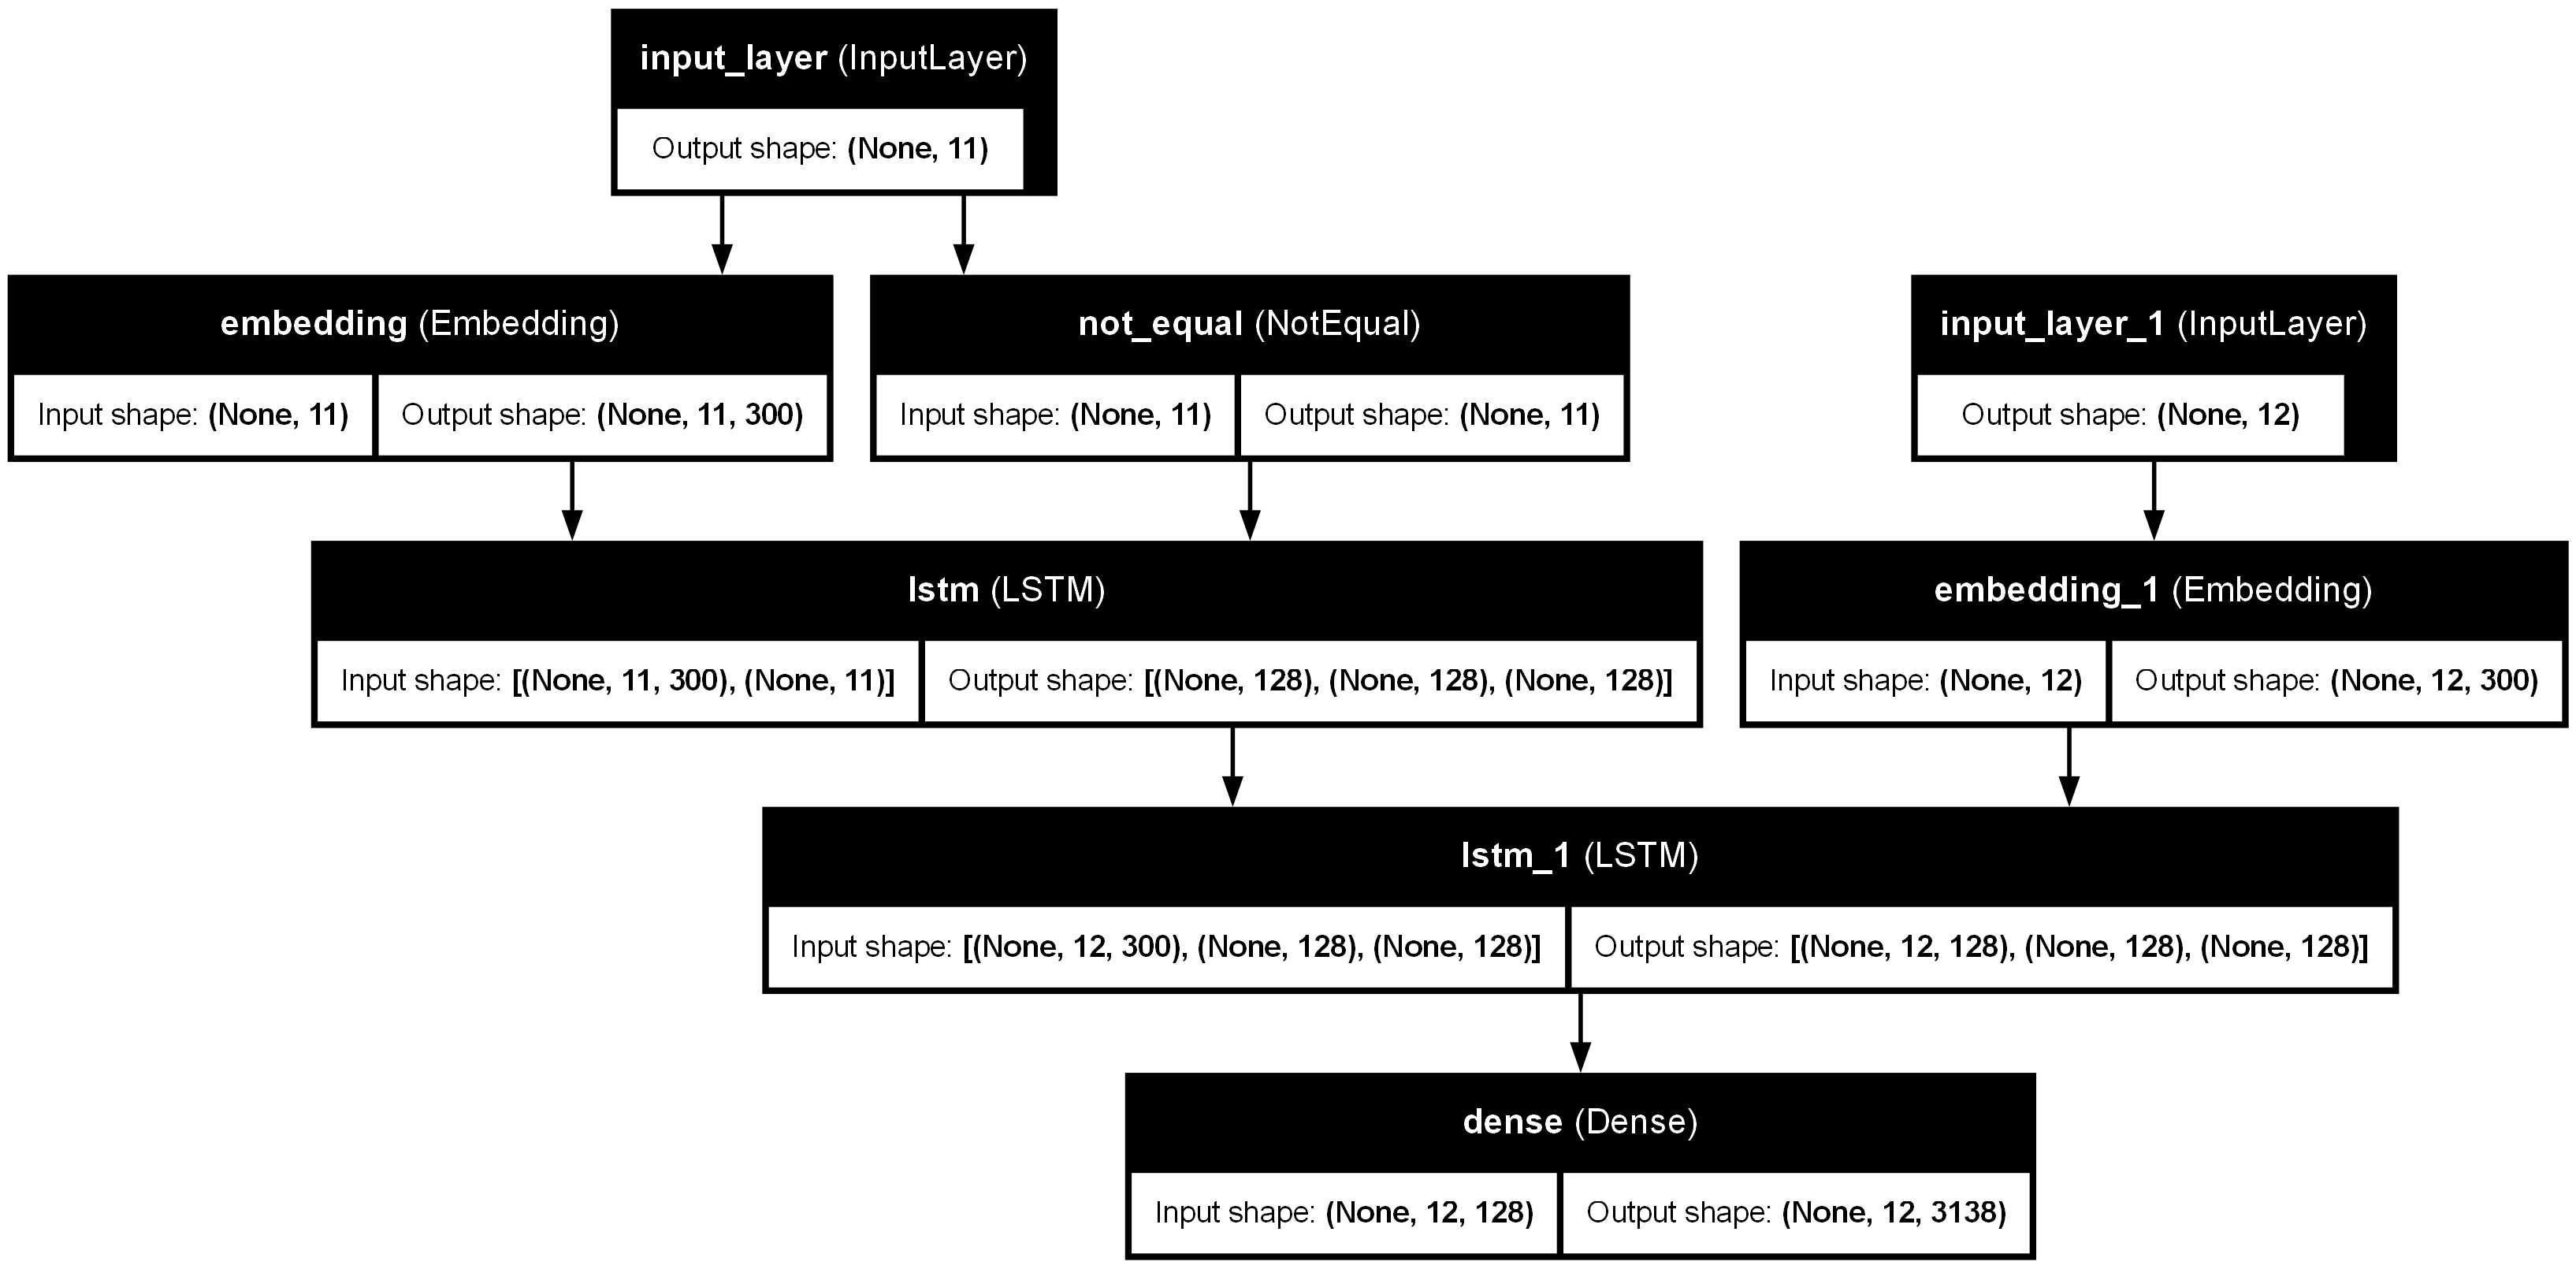

In [17]:
from IPython.display import Image, display
# Graficar el modelo completo para entrenamiento
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

display(Image(filename='model_plot.png'))

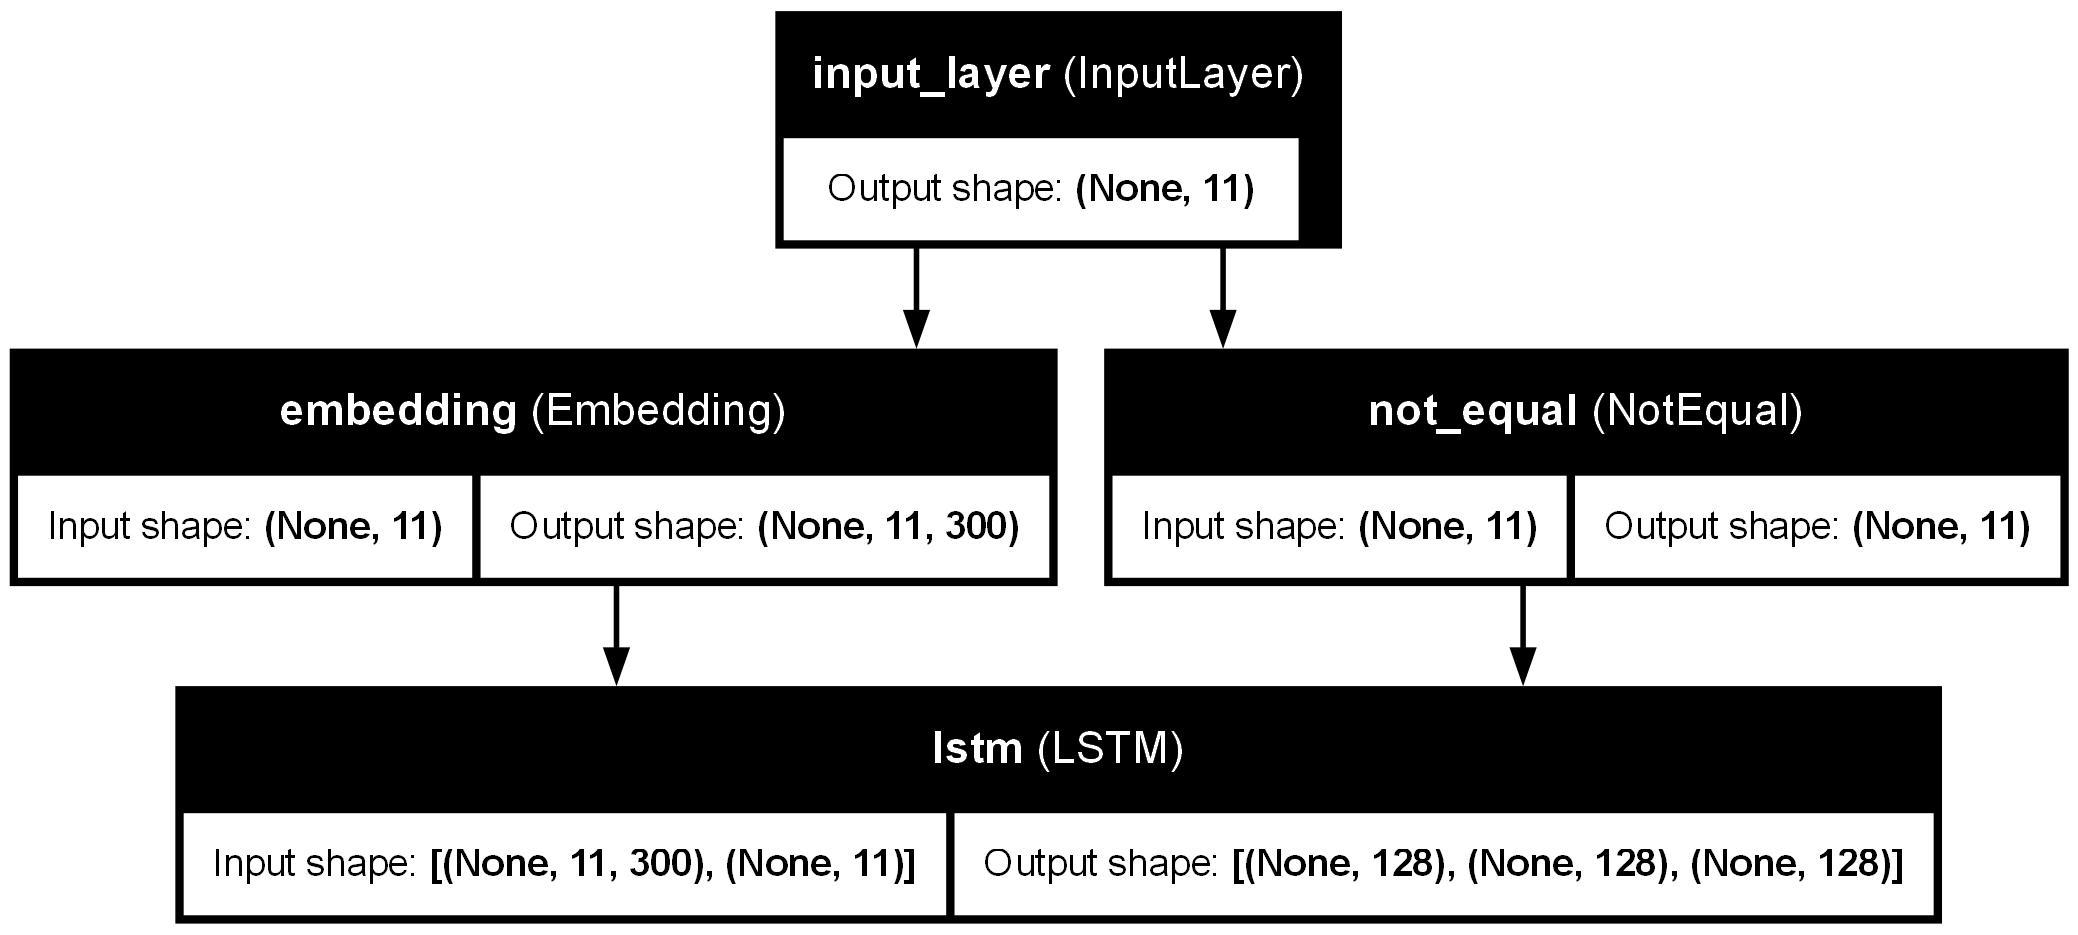

In [18]:
# Definir el modelo solo encoder (para la inferencia)
encoder_model = Model(encoder_inputs, encoder_states)

# Graficar
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='encoder_plot.png'))

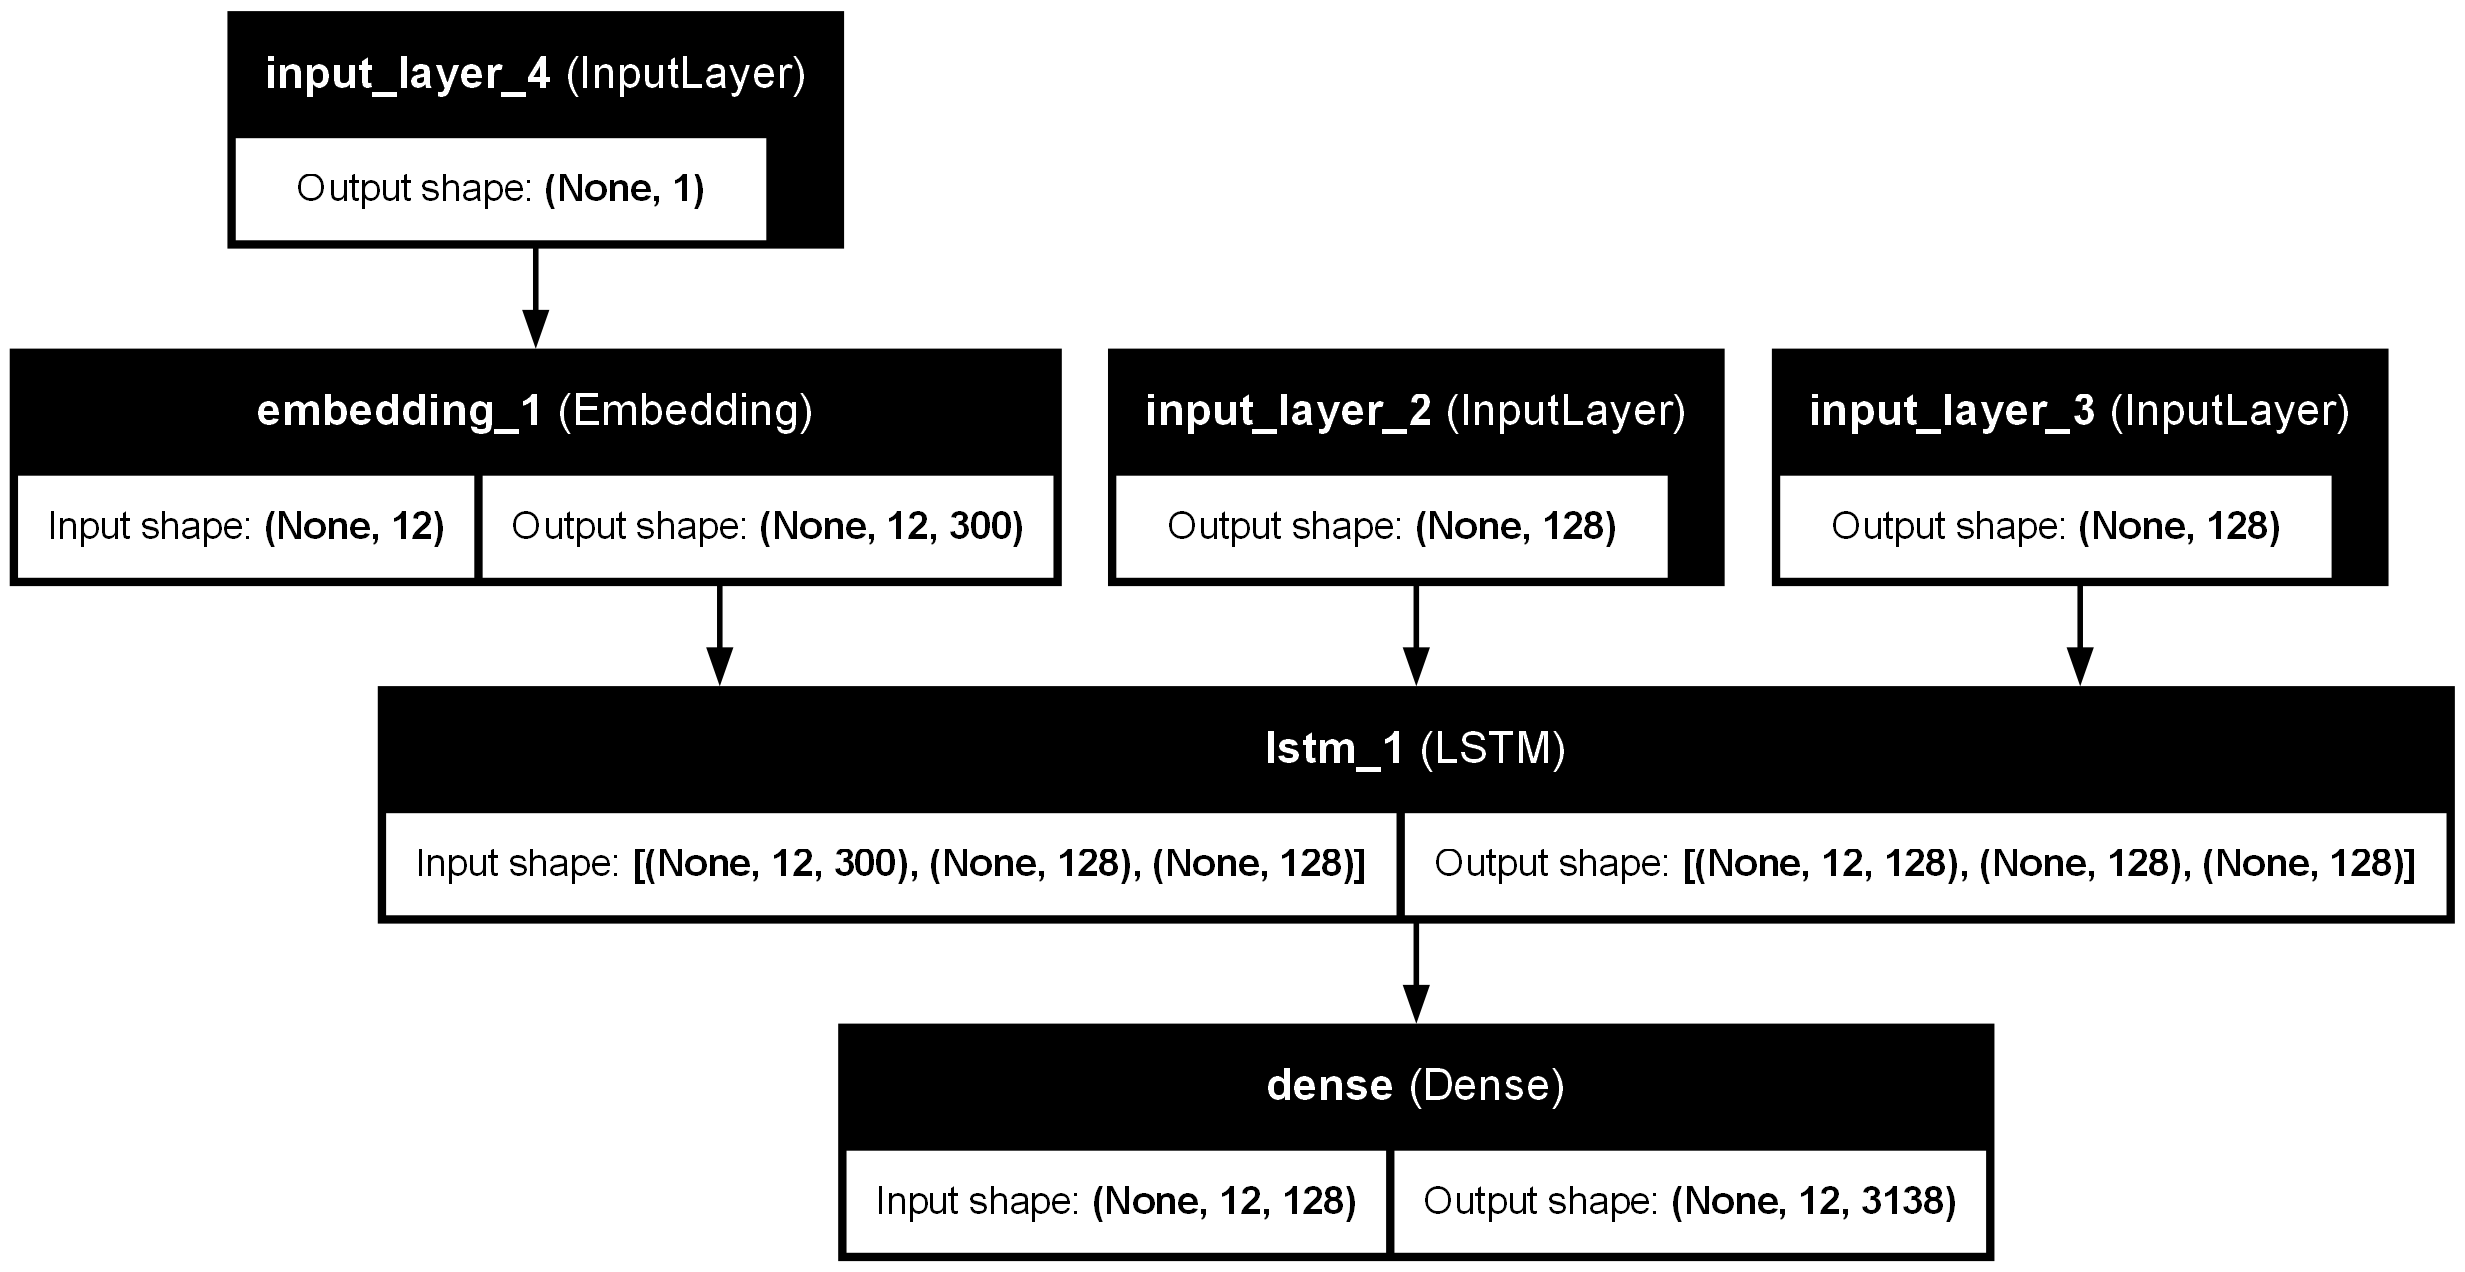

In [19]:
# Definir el modelo Decoder  (para la inferencia)

decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Entrada para una sola palabra por paso
decoder_inputs_single = Input(shape=(1,))

# Capa de embedding
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM del decoder 
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Capa final densa (softmax)
decoder_outputs = decoder_dense(decoder_outputs)

# --- MODELO INFERENCIA---
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Graficar
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='decoder_plot.png'))

Epoch 1/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4928 - loss: 3.9940
Epoch 1: val_loss improved from inf to 2.32508, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4932 - loss: 3.9861 - val_accuracy: 0.6216 - val_loss: 2.3251 - learning_rate: 0.0010
Epoch 2/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6181 - loss: 2.2162
Epoch 2: val_loss improved from 2.32508 to 2.09596, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6182 - loss: 2.2157 - val_accuracy: 0.6526 - val_loss: 2.0960 - learning_rate: 0.0010
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6575 - loss: 1.9549
Epoch 3: val_loss improved from 2.09596 to 1.96091, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6576 - loss: 1.9547 - val_accuracy: 0.6776 - val_loss: 1.9609 - learning_rate: 0.0010
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6898 - loss: 1.7406
Epoch 4: val_loss improved from 1.96091 to 1.87612, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6898 - loss: 1.7406 - val_accuracy: 0.6880 - val_loss: 1.8761 - learning_rate: 0.0010
Epoch 5/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6991 - loss: 1.6426
Epoch 5: val_loss improved from 1.87612 to 1.82023, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6992 - loss: 1.6425 - val_accuracy: 0.6949 - val_loss: 1.8202 - learning_rate: 0.0010
Epoch 6/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7071 - loss: 1.5758
Epoch 6: val_loss improved from 1.82023 to 1.78452, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7071 - loss: 1.5756 - val_accuracy: 0.6990 - val_loss: 1.7845 - learning_rate: 0.0010
Epoch 7/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7178 - loss: 1.4829
Epoch 7: val_loss improved from 1.78452 to 1.76137, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7178 - loss: 1.4830 - val_accuracy: 0.7016 - val_loss: 1.7614 - learning_rate: 0.0010
Epoch 8/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7210 - loss: 1.4473
Epoch 8: val_loss improved from 1.76137 to 1.74884, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7210 - loss: 1.4472 - val_accuracy: 0.7037 - val_loss: 1.7488 - learning_rate: 0.0010
Epoch 9/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7275 - loss: 1.3719
Epoch 9: val_loss improved from 1.74884 to 1.72660, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7275 - loss: 1.3720 - val_accuracy: 0.7063 - val_loss: 1.7266 - learning_rate: 0.0010
Epoch 10/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7295 - loss: 1.3405
Epoch 10: val_loss improved from 1.72660 to 1.71688, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7295 - loss: 1.3405 - val_accuracy: 0.7091 - val_loss: 1.7169 - learning_rate: 0.0010
Epoch 11/50
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7365 - loss: 1.2934
Epoch 11: val_loss improved from 1.71688 to 1.71014, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7365 - loss: 1.2935 - val_accuracy: 0.7127 - val_loss: 1.7101 - learning_rate: 0.0010
Epoch 12/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7383 - loss: 1.2608
Epoch 12: val_loss did not improve from 1.71014
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7383 - loss: 1.2607 - val_accuracy: 0.7123 - val_loss: 1.7149 - learning_rate: 0.0010
Epoch 13/50
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7466 - loss: 1.2060
Epoch 13: val_loss improved from 1.71014 to 1.71010, saving model to best_seq2seq.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7466 - loss: 1.2062 - val_accuracy: 0.7128 - val_loss: 1.7101 - learning_rate: 0.0010
Epoch 14/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7489 - loss: 1.1722
Epoch 14: val_loss improved from 1.71010 to 1.70699, saving model to best_seq2seq.h5


266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7489 - loss: 1.1722 - val_accuracy: 0.7148 - val_loss: 1.7070 - learning_rate: 5.0000e-04
Epoch 15/50
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7484 - loss: 1.1630
Epoch 15: val_loss did not improve from 1.70699
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7484 - loss: 1.1630 - val_accuracy: 0.7139 - val_loss: 1.7094 - learning_rate: 5.0000e-04
Epoch 16/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7542 - loss: 1.1293
Epoch 16: val_loss did not improve from 1.70699

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7542 - loss: 1.1293 - val_accuracy: 0.7141 - val_loss: 1.7118 - learning_rate: 5.0000e-04
Epoch 17/50
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7534 - loss: 1.1235
Epoch 17: val_loss did not improve from 1.70699
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7534 - loss: 1.1234 

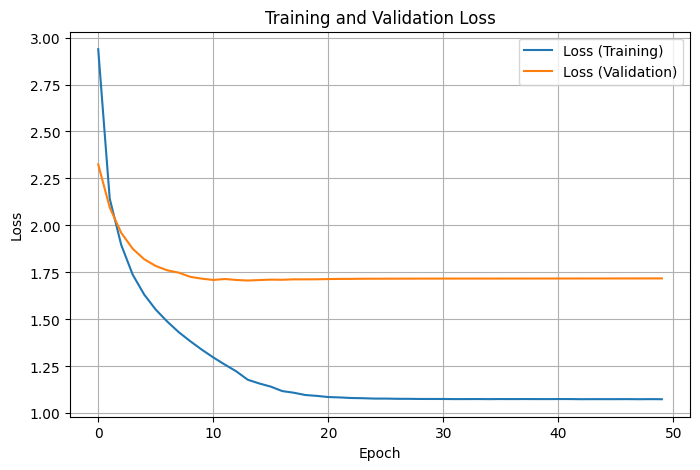

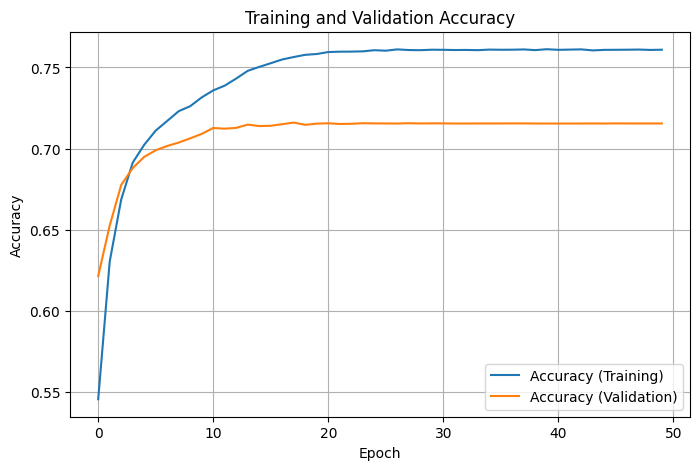

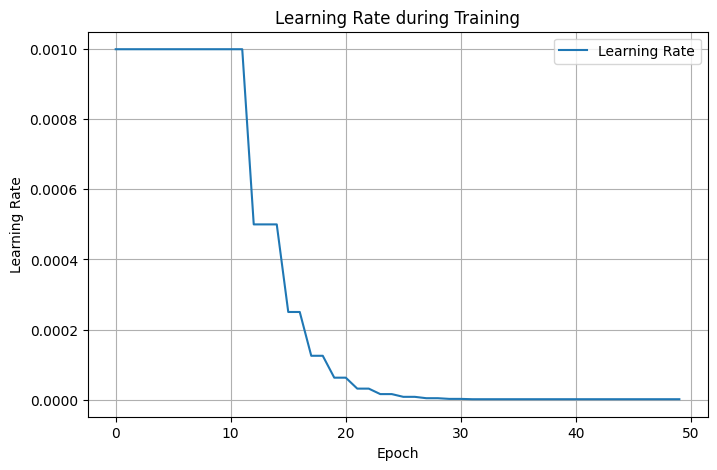

Learning rate final: 0.00000100


In [20]:
# Clase para learning rate track
class LearningRateTracker(Callback):
    def on_train_begin(self, logs=None):
        self.lrates = []
    def on_epoch_end(self, epoch, logs=None):
        lr = lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        self.lrates.append(lr)

# Crear instancia
lr_tracker = LearningRateTracker()

# Callbacks
callbacks = [
#    EarlyStopping(
#        monitor='val_loss',
#        patience=10,
#        restore_best_weights=True
#    ),
    ModelCheckpoint(
        filepath='best_seq2seq.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    lr_tracker 
]

# Entrenar
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks
)

# Graficar

# 1) Pérdida
plt.figure(figsize=(8,5))
plt.plot(hist.history['loss'], label='Loss (Training)')
plt.plot(hist.history['val_loss'], label='Loss (Validation)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2) Precisión
plt.figure(figsize=(8,5))
plt.plot(hist.history['accuracy'], label='Accuracy (Training)')
plt.plot(hist.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 3) Learning Rate
plt.figure(figsize=(8,5))
plt.plot(lr_tracker.lrates, label='Learning Rate')
plt.title('Learning Rate during Training')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()
plt.show()

# 4) Print
final_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
print(f"Learning rate final: {final_lr:.8f}")


**Conclusión del entrenamiento**

La pérdida en el conjunto de entrenamiento muestra una mejora constante y sostenida. En cambio, la pérdida en validación desciende inicialmente para luego estabilizarse, comenzando con sobreajuste.

La accuracy alcanzó ≈ 77 % en entrenamiento y ≈ 71 % en validación, con ambas curvas estabilizadas desde la época 20 con una diferencia constante de aproximadamente 6 puntos. 

# 6. Inferencia

In [21]:
# Crear diccionarios
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}


In [22]:
# Funcion de inferencia

def get_answer(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']

    output_sentence = []

    for _ in range(max_out_len):
        # Predecir el siguiente token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si se genera <eos>, terminar la inferencia
        if eos == idx:
            break

        # Convertir el índice a palabra
        word = idx2word_target.get(idx, '')
        if word:
            output_sentence.append(word)

        # Actualizar los estados
        states_value = [h, c]

        # Actualizar la entrada al decoder
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)


In [23]:
# Prueba de inferencia aleatoria
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = get_answer(input_seq)

# Mostrar el input original y la respuesta
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
-
Input: do you have any hobbies
Response: i do not have a lot of time for that


In [24]:
# Funcion ask_bot
def ask_bot(input_test):
    # Limpiar
    input_test_clean = clean_text(input_test)

    # Pasar a índices
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test_clean])[0]

    # Aplicar padding
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

    # Obtener la respuesta
    answer = get_answer(encoder_sequence_test)

    return answer

In [25]:
ask_bot("Hi")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'hello how are you'

In [26]:
ask_bot("Do you read")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'i do not have any pets'

In [27]:
ask_bot("Do you have any pet")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'i do not have a lot of time for that'

In [28]:
ask_bot("Where are you from")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


'i am from the united states how about you'

**Conclusiones:**
El modelo logra generar respuestas simples (por ejemplo, saluda correctamente y responde con ubicaciones). Sin embargo, tiende a repetir respuestas frecuentes y no siempre capta el significado de las preguntas, como se observa cuando responde sobre mascotas a consultas no relacionadas.